### Install Dependency

In [ ]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install scipy
# %pip install statsmodels
# %pip install arch
%pip install pmdarima

### Imports

In [1]:
#Python 3.10.8 statsmodels 0.14.0.dev598+g46116c493
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error
from arch import arch_model
import pmdarima as pmd
from colorama import Fore
import warnings
warnings.filterwarnings("ignore")
register_matplotlib_converters()

### Retrive data from .csv file

In [146]:
#Read data
csv_file = 'CPIUSSA.csv'
df = pd.read_csv('DataSet\\'+csv_file)
df.dropna(inplace=True)
df.head()

,DATE,CPILFESL
0,1957-01-01,28.5
1,1957-02-01,28.6
2,1957-03-01,28.7
3,1957-04-01,28.8
4,1957-05-01,28.8


### Require Dataframe with format (datetime , Time Series data) only

### Data Cleaning

In [228]:
#Data cleaning
df_clean = df.loc[:,['DATE','CPILFESL']]
df_clean = df.loc[:,['DATE','CPILFESL']]
df_clean.rename(columns={'DATE':'date','CPILFESL':'cpi'},inplace=True)
df_clean['date'] = pd.to_datetime(df_clean.date)
df_clean['cpi'] = df_clean['cpi'].astype(float)
df.dropna(inplace=True)
#Subseting data, Leave some data for forcecasting
df_clean.set_index('date',inplace=True)
df_raw = df_clean.copy()
start_year, end_year = 2000, 2019
start_date = pd.to_datetime(str(start_year) + '-01-01')
end_date = pd.to_datetime(str(end_year) +'-05-01')
df_clean = df_clean[start_date:end_date]

df_com = df_raw[pd.to_datetime('2019-06-01'):pd.to_datetime('2019-11-01')]
df.dropna(inplace=True)
df_train = df_clean.copy()
df_clean.tail()

,cpi
date,
2019-01-01,260.534
2019-02-01,260.885
2019-03-01,261.382
2019-04-01,261.958
2019-05-01,262.321


### Useful function for printing out test output

In [207]:
#Augmented Dickey-Fuller (ADF) Test:
#Null hypothesis: non-stationary - if p-value < 5% reject null hypothesis
def ADFtest(dataframe, column):
    adfuller_result = adfuller(dataframe[column].values, autolag='AIC')
    print(f'ADF statistic: {adfuller_result[0]}')
    print(f'p-value      : {adfuller_result[1]}')
    for key, value in adfuller_result[4].items():
        print('Critical values:')
        print(f'  {key},  {value}')
    if (adfuller_result[1] <= 0.05):
        print(Fore.GREEN + f'It is stationary (p-value: {adfuller_result[1]})')
    else:
        print(Fore.LIGHTRED_EX + f'It is non-stationary (p-value: {adfuller_result[1]})')

#The additive model is useful when the seasonal variation is relatively constant over time.
#The multiplicative model is useful when the seasonal variation increases over time.
def seasonDecomposer(dataframe, column, models='additive', periods=1):
    plt.rcParams.update({'figure.figsize':(20,10)})
    seasonal_decompose(dataframe[column], model=models, period=periods).plot().suptitle(f'\n{models} decompose', fontsize=12)

#Combine all funtions
def plotAll(dataframe, column, plottitle, operator ,plotylabel, startyear, endyear, models='additive', periods=1, lag=30, season=True):
    ADFtest(dataframe, column)
    plt.figure(figsize=(20,4))
    plt.plot(dataframe[column])
    plt.title(f'{plottitle} {operator}', fontsize=20)
    plt.ylabel(plotylabel, fontsize=16) 
    for year in range(startyear,endyear):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    # “ywm” : Yule-Walker without adjustment. Default.
    # “yw”  : Yule-Walker with sample-size adjustment in denominator for acovf. Default.
    #alpha  : 0.05 = 95% confidence interval
    plt.rcParams.update({'figure.figsize':(20,4)})
    plot_acf(dataframe[column],  alpha=.05, lags=lag, title=f'ACF {operator}')
    plot_pacf(dataframe[column],  alpha=.05, method='ywm',lags=lag, title=f'PACF {operator}')
    if (season):
        seasonDecomposer(dataframe, column, models, periods)

#Check all stationarity after log and differencing
def allStationarity(dataframe,column):
    dataframe['after_log'] = np.log(dataframe[column])
    dataframe['difference_1'] = dataframe[column] - dataframe[column].shift(1)
    dataframe['difference_2'] = dataframe[column] - 2*dataframe[column].shift(1) + dataframe[column].shift(2)
    dataframe['log_difference_1'] = dataframe['after_log'] - dataframe['after_log'].shift(1)
    dataframe['log_difference_2'] = dataframe['after_log'] - 2*dataframe['after_log'].shift(1) + dataframe['after_log'].shift(2)
    dataframe['log_diff1_rseason'] = dataframe['after_log'].diff().diff(12)
    dataframe['diff1_rseason'] = dataframe['difference_1'].diff().diff(12)
    dataframe.dropna(inplace=True)
    for data in [column,'after_log','difference_1','difference_2','log_difference_1','log_difference_2','log_diff1_rseason','diff1_rseason']:
        adfuller_result = adfuller(dataframe[data].values, autolag='AIC')
        if (adfuller_result[1] <= 0.05):
            print(Fore.GREEN + f'{data} : stationary (p-value: {adfuller_result[1]})')
        else:
            print(Fore.LIGHTRED_EX + f'{data} : non-stationary (p-value: {adfuller_result[1]})')

#Ljung-Box test for serial correlation of standardized residuals
def lgBoxResult(result):
    test_stat = result[0][0]
    p_value = result[0][1]
    for i in range(len(test_stat)):
        print(Fore.RESET + f'At Lag: {i}, Test statistic: {test_stat[i]}, p-value:{p_value[i]}')
        if (p_value[i] <= 0.05):
            print(Fore.LIGHTRED_EX + f'p-value =< 0.05, Null hypothesis is rejected, there is serial correlation.')
        else:
            print(Fore.GREEN + f'p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.')
        print(Fore.RESET + '------------------------------------------------------------------------------------------')

#Shapiro-Wilk normality test
def shapiro_test(np_array):
    '''
    https://github.com/scipy/scipy/blob/v1.9.3/scipy/stats/_morestats.py#L1727-L1802
    The chance of rejecting the null hypothesis when it is true is close to 5%
    regardless of sample size.
    '''
    shapiro_result = shapiro(np_array)
    print('-------------------------------Shapiro-Wilk normality test Result------------------------------')
    print(f'Test statistic: {shapiro_result.statistic}')
    print(f'p-value       : {shapiro_result.pvalue}')
    if (shapiro_result.pvalue <= 0.05):
        print(Fore.LIGHTRED_EX + f'p-value <= 0.05, Null hypothesis is rejected, data was NOT drawn from a normal distribution.')
    else:
        print(Fore.GREEN + f'p-value > 0.05, Null hypothesis is not rejected, data was drawn from a normal distribution.')
    print(Fore.RESET + '-----------------------------------------------------------------------------------------------')

def plotResid(std_resid_array,startyear,endyear):
    plt.figure(figsize=(10,4))
    plt.plot(std_resid_array)
    plt.title('Squared Residuals Sequence', fontsize=20)
    plt.ylabel('Squared Residuals', fontsize=16)
    for year in range(startyear,endyear):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

### Original Time Series data plot with stationarity, seasonality check

ADF statistic: 1.4606337982699442
p-value      : 0.9973729123021289
Critical values:
  1%,  -3.459105583381277
Critical values:
  5%,  -2.8741898504150574
Critical values:
  10%,  -2.5735117958412097
It is non-stationary (p-value: 0.9973729123021289)


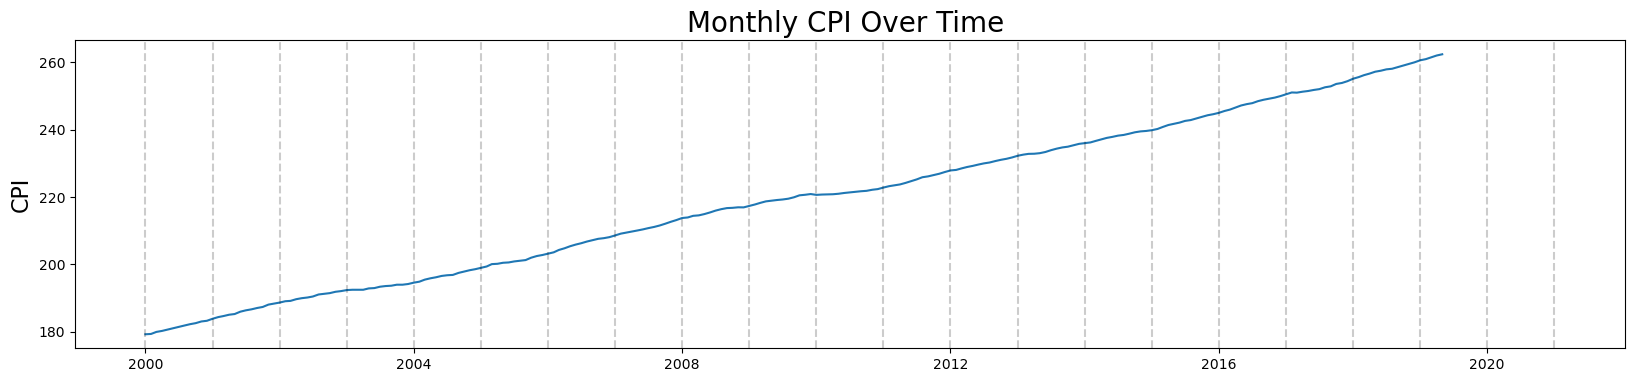

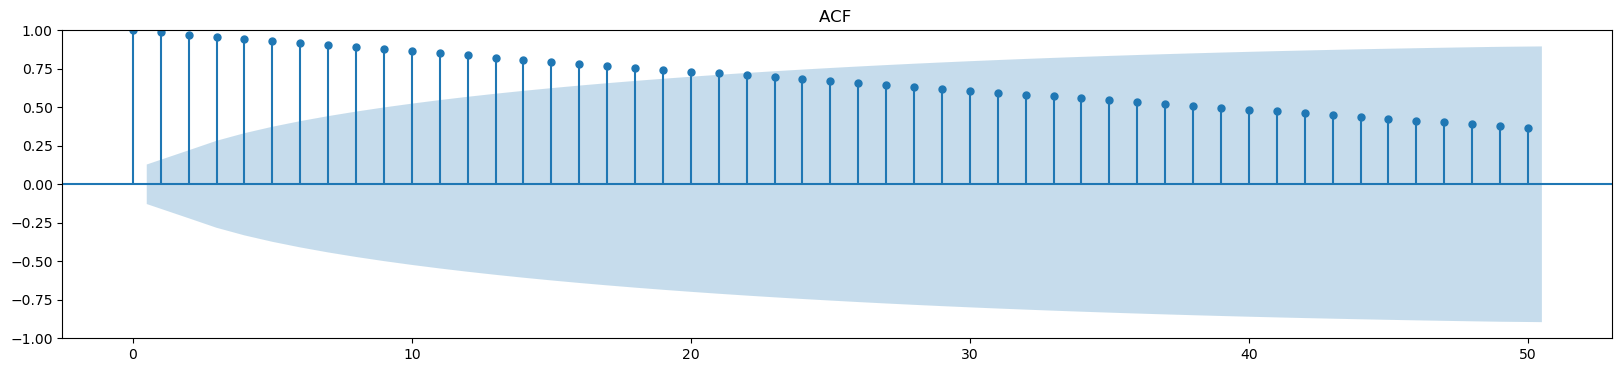

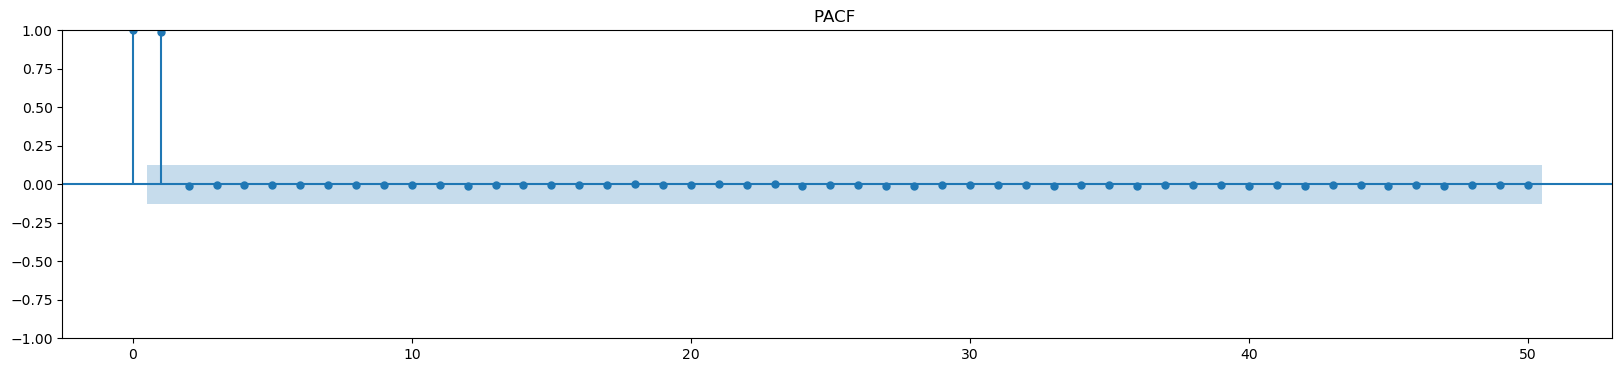

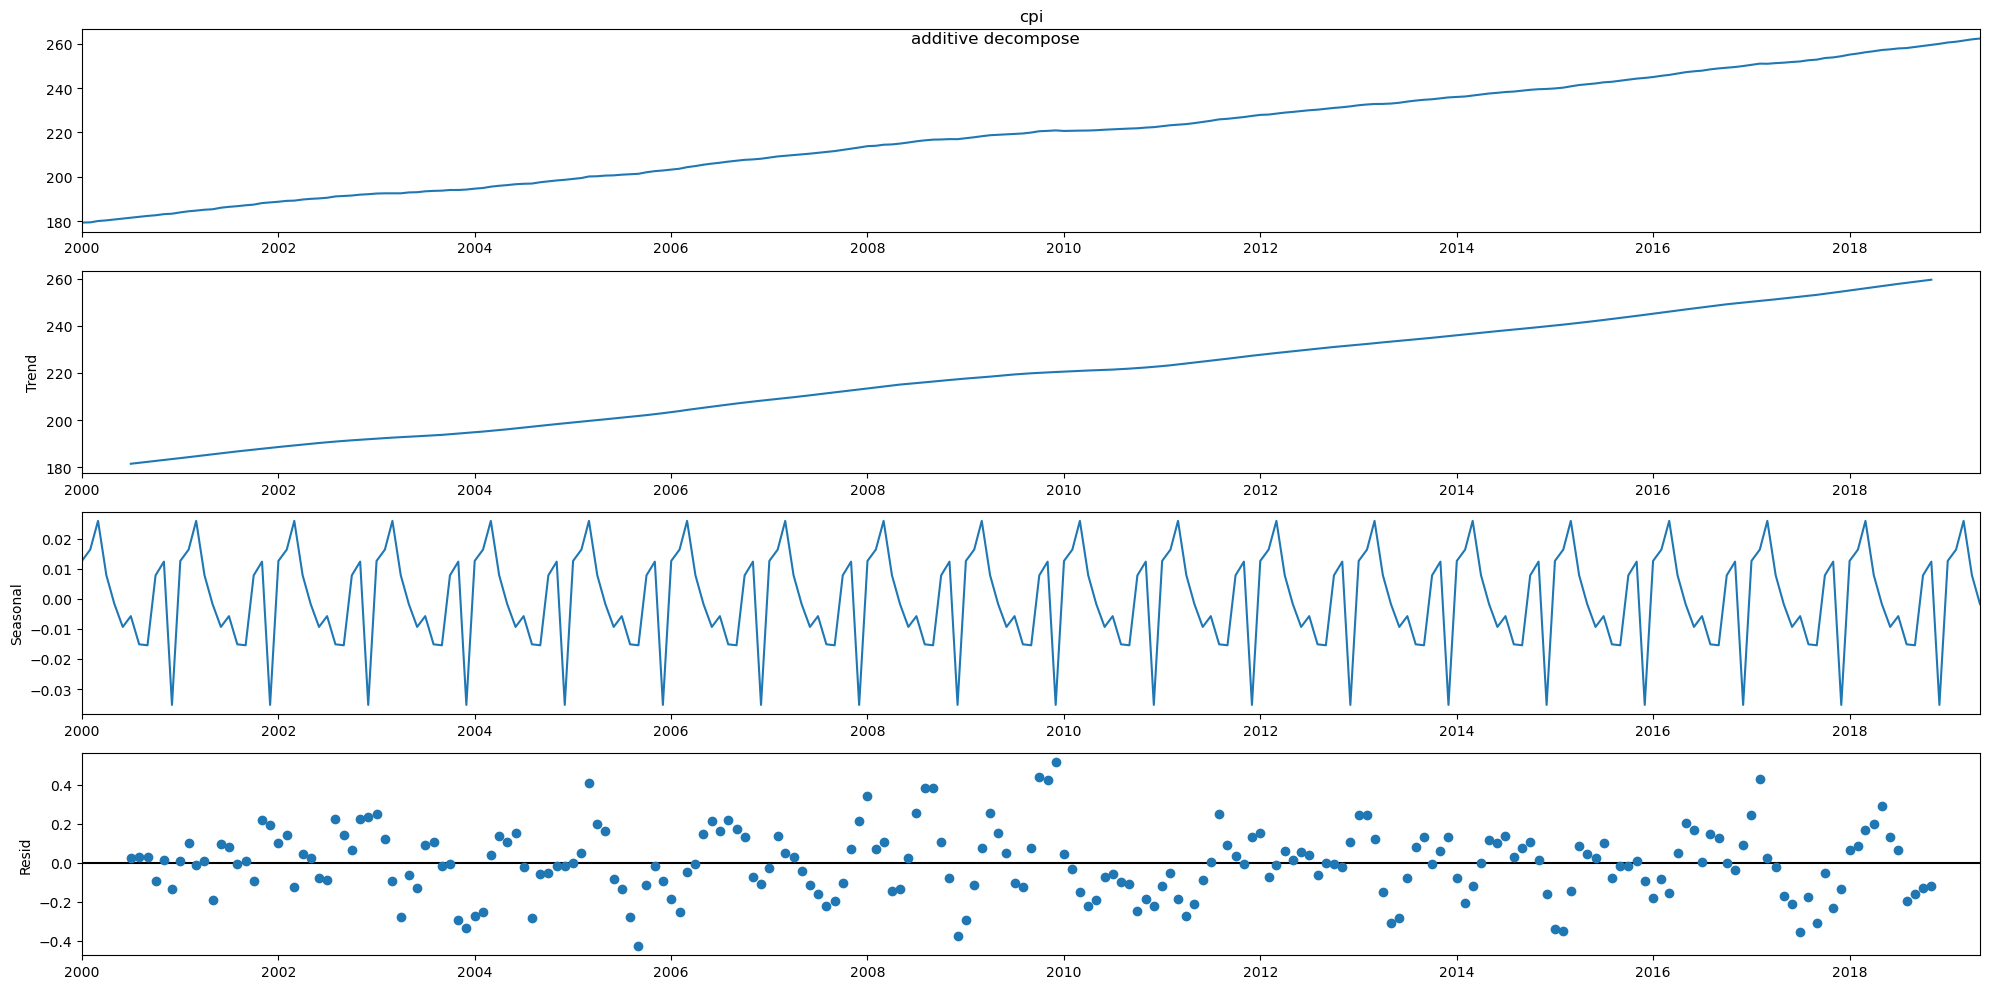

In [202]:
#https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_goldfeldquandt.html
plotAll(df_clean, column='cpi', plottitle='Monthly CPI Over Time', operator='', plotylabel='CPI', startyear=start_year, endyear=end_year+3, models='additive', periods=12, lag=50)

### Calculating all the possible Time Series data transformation

Please run this before running the below graph plotting

In [203]:
#All stationarity result after log and differencing
allStationarity(df_clean,'cpi')
df_log = df_clean[['after_log']]
df_log.rename(columns={"after_log": "cpi"}, inplace=True)

df_difference_2  = df_clean[['difference_2']]
df_difference_2.rename(columns={"difference_2": "cpi"}, inplace=True)

df_diff1_rseason  = df_clean[['diff1_rseason']]
df_diff1_rseason.rename(columns={"diff1_rseason": "cpi"}, inplace=True)

cpi : non-stationary (p-value: 0.9979567594426473)
after_log : non-stationary (p-value: 0.971715831511965)
difference_1 : stationary (p-value: 0.0168790643303712)
difference_2 : stationary (p-value: 2.1849471600130713e-09)
log_difference_1 : stationary (p-value: 0.004242435598495543)
log_difference_2 : stationary (p-value: 1.4662294225026218e-09)
log_diff1_rseason : stationary (p-value: 0.00018061891250407264)
diff1_rseason : stationary (p-value: 1.4529474618396533e-08)


### Graph ploting after transformation with stationartiy check

ADF statistic: -3.2576879769138367
p-value      : 0.0168790643303712
Critical values:
  1%,  -3.4620315036789666
Critical values:
  5%,  -2.8754705024827127
Critical values:
  10%,  -2.5741950726860647
It is stationary (p-value: 0.0168790643303712)


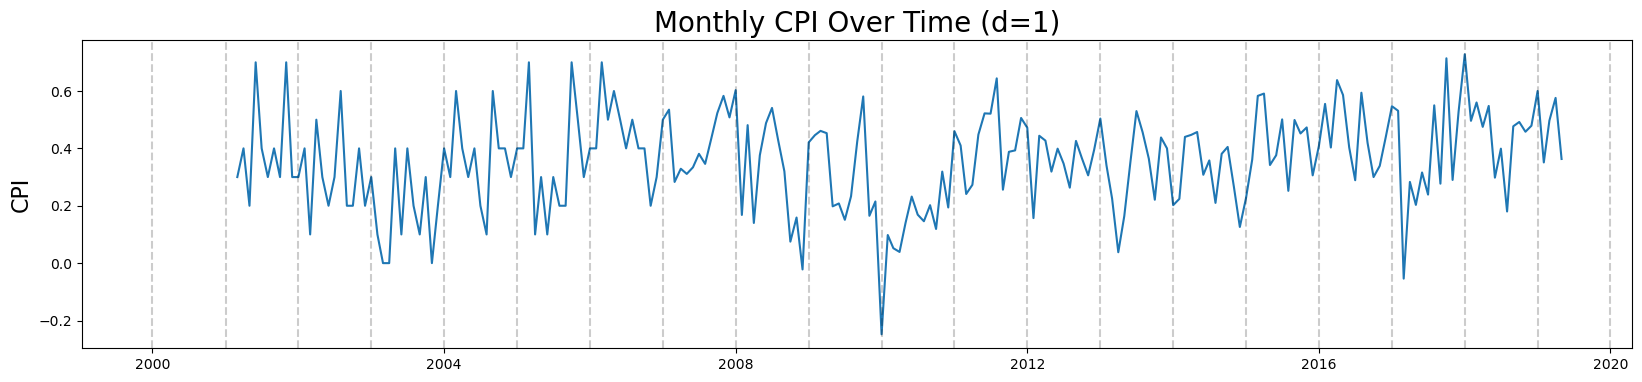

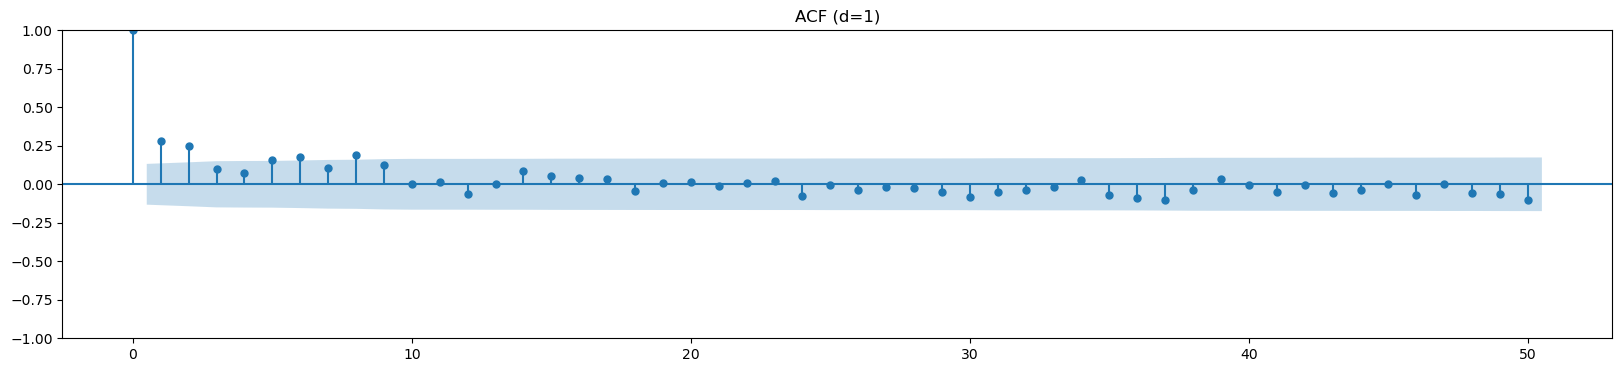

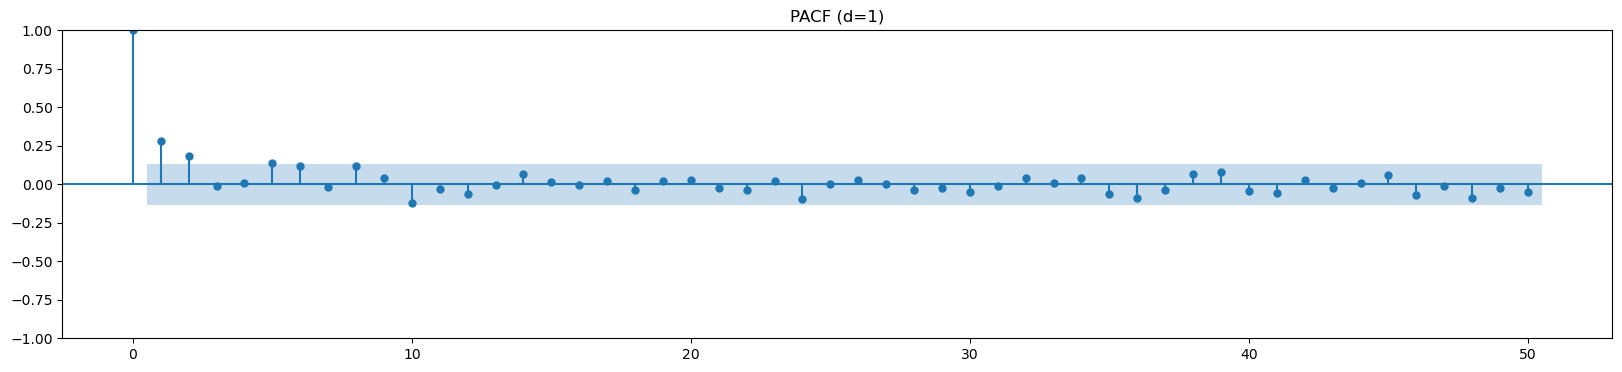

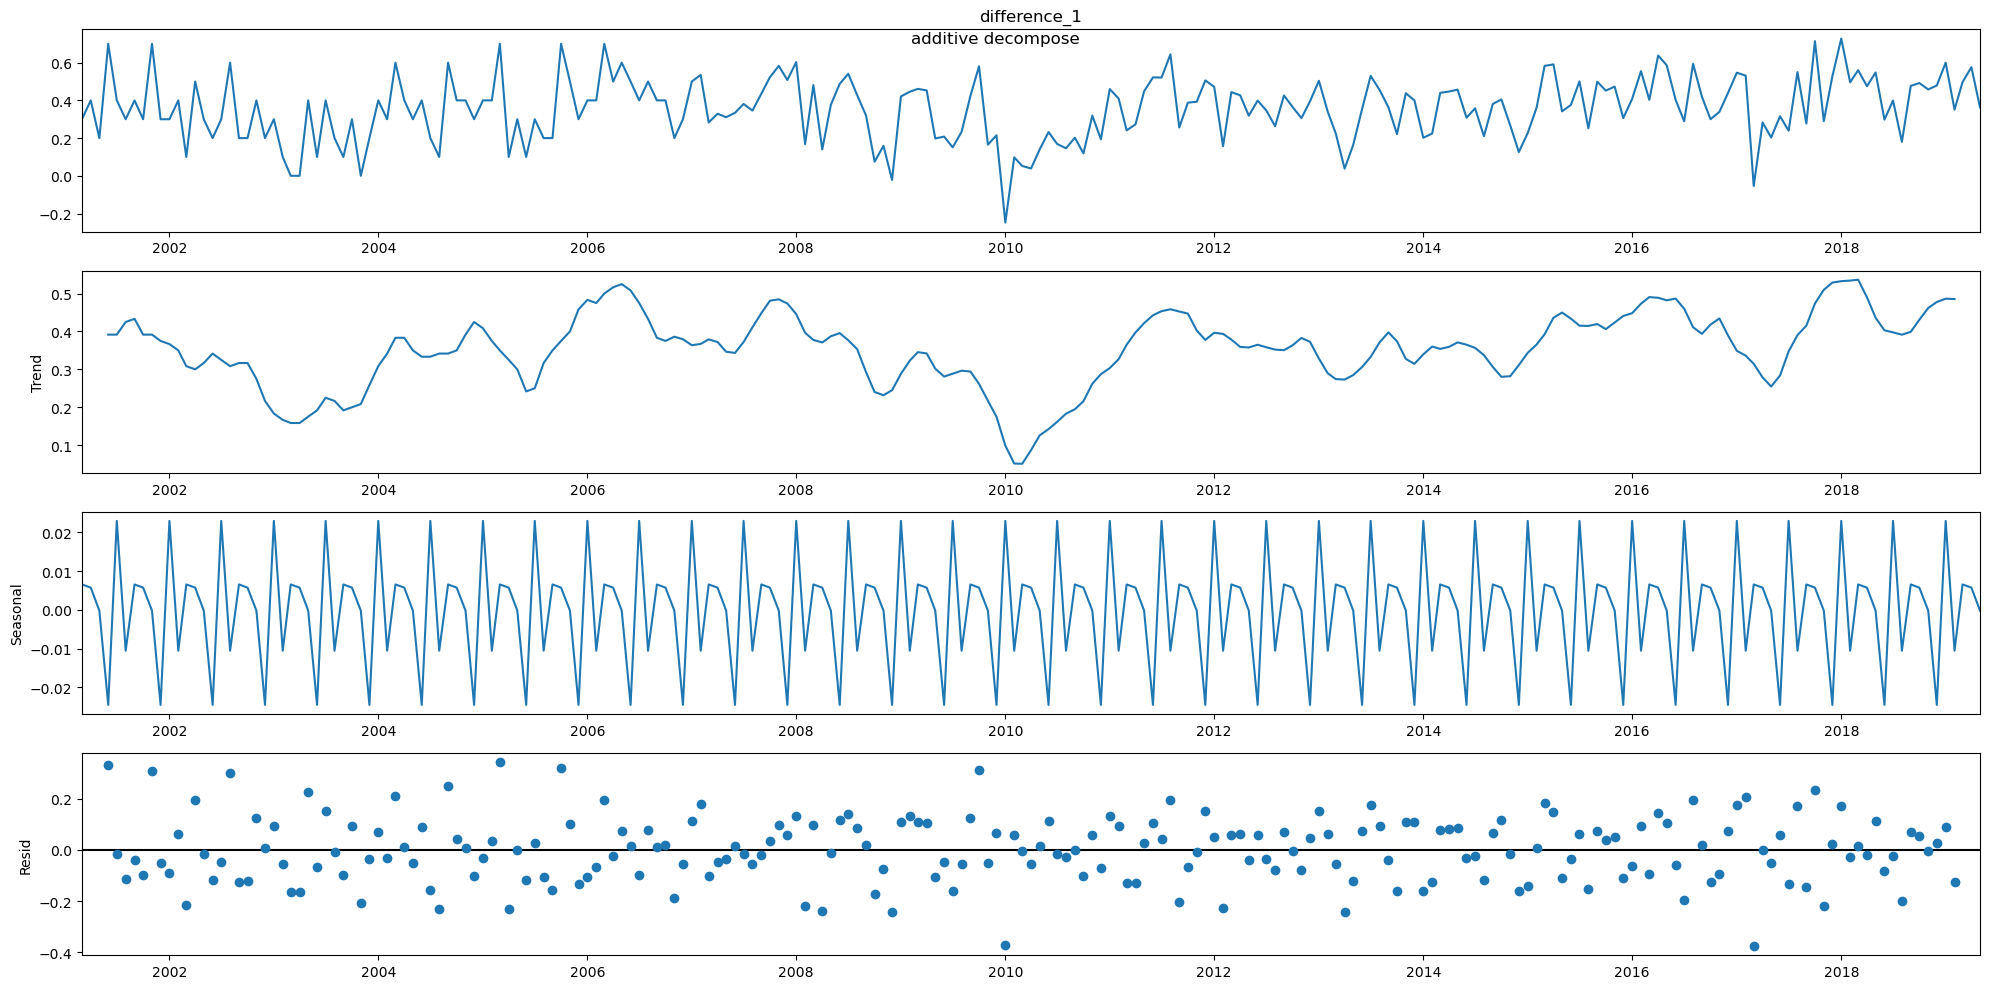

In [204]:
#Log Transformation
# ['after_log','difference_1','difference_2','log_difference_1','log_difference_2', 'log_diff1_rseason']
# plotAll(dataframe, column, plottitle, plotylabel, startyear, endyear, models='additive', periods=1) multiplicative
plotAll(df_clean, column='difference_1', plottitle='Monthly CPI Over Time', operator='(d=1)', plotylabel='CPI', startyear=start_year, endyear=end_year+2, models='additive', periods=6, lag=50, season=True)

### Model fitting, please fit a model according to the ACF and PACF plot

In [240]:
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels-tsa-arima-model-arima
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.html#statsmodels-tsa-arima-model-arimaresults
#https://github.com/statsmodels/statsmodels/issues/6212
#Use df_log for logged data, use df_train for original data  | seasonal_order=(P,D,Q,s) if the seasonal cycles is same shape then (D = 0)
p,d,q = 0,1,8
P,D,Q,s = 0,0,0,12
model = ARIMA(df_train, order=(p,d,q), seasonal_order=(P,D,Q,s), enforce_stationarity=False, enforce_invertibility=False)
#Using Maximum likelihood estimation
model_fit = model.fit(method='innovations_mle')
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    cpi   No. Observations:                  233
Model:                 ARIMA(0, 1, 8)   Log Likelihood                  54.984
Date:                Sat, 26 Nov 2022   AIC                            -91.968
Time:                        04:12:09   BIC                            -61.304
Sample:                    01-01-2000   HQIC                           -79.589
                         - 05-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5264      0.074      7.078      0.000       0.381       0.672
ma.L2          0.6043      0.078      7.767      0.000       0.452       0.757
ma.L3          0.3983      0.088      4.515      0.0

### Residual Analysis
#### Ljung-Box test for model adequacy

In [241]:
'''
https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.test_serial_correlation.html
Ljung-Box test for serial correlation of standardized residuals (check the adequacy)
Null hypothesis is no serial correlation.
df_adjust: when true df = k-p-q
lags: default maxlag is min(10, number of observation//5), (lags is K)
'''
result = model_fit.test_serial_correlation(method='ljungbox',df_adjust=True, lags=10)
lgBoxResult(result)

At Lag: 0, Test statistic: 6.487015861305966, p-value:nan
p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.
------------------------------------------------------------------------------------------
At Lag: 1, Test statistic: 10.753799928018015, p-value:nan
p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.
------------------------------------------------------------------------------------------
At Lag: 2, Test statistic: 11.92369085785821, p-value:nan
p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.
------------------------------------------------------------------------------------------
At Lag: 3, Test statistic: 12.7816381450517, p-value:nan
p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.
------------------------------------------------------------------------------------------
At Lag: 4, Test statistic: 13.529998340490652, p-value:nan
p-value > 0.05, Null 

#### Standardized Residual: Sequence, Histogram, Q-Q plot, Correlogram, ACF, PACF

-------------------------------Shapiro-Wilk normality test Result------------------------------
Test statistic: 0.9952702522277832
p-value       : 0.7213530540466309
p-value > 0.05, Null hypothesis is not rejected, data was drawn from a normal distribution.
-----------------------------------------------------------------------------------------------
Figure(1000x1000)
Figure(1000x400)
Figure(1000x400)


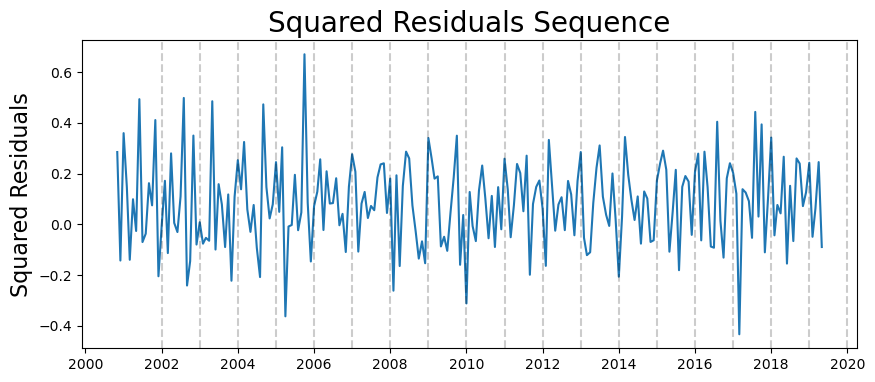

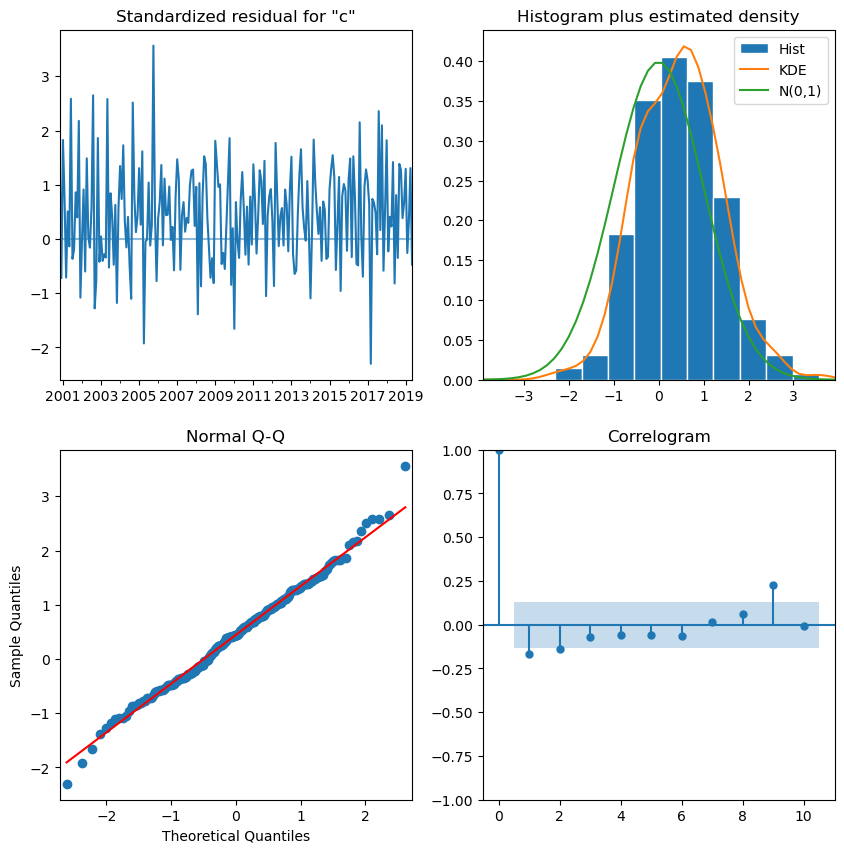

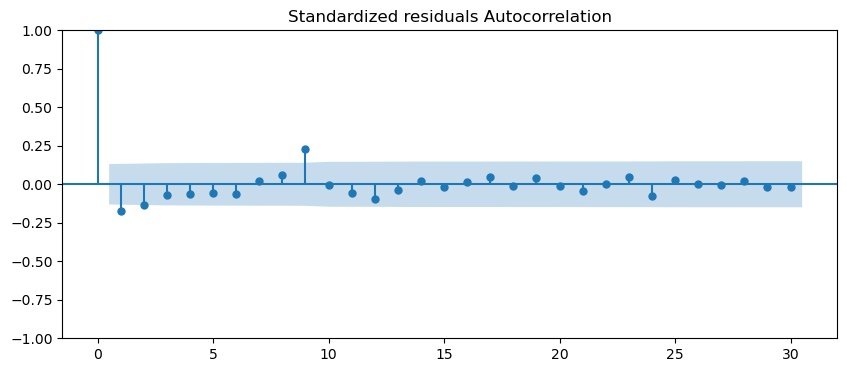

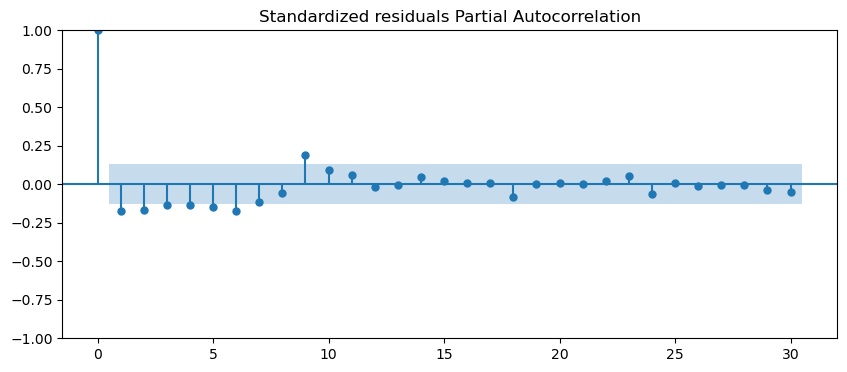

In [242]:
'''Test for normality of standardized residuals'''

#extract residuals sequence and calculate standardized residuals sequence
resid = model_fit.resid[model.loglikelihood_burn:]
# std_resid = resid / resid.std()
sqrd_resid = np.power(resid,2)
plotResid(resid, start_year+2, end_year+2)

#Shapiro-Wilk normality test
#Null hypothesis: data was drawn from a normal distribution
shapiro_test(resid)

#Standardized residual sequence, Histogram, Q-Q plot, correlogram
print(model_fit.plot_diagnostics(figsize=(10,10)))

#ACF and PACF of the residuals
plt.rcParams.update({'figure.figsize':(10,4)})
print(plot_acf(resid,  alpha=.05, lags=30, title='Standardized residuals Autocorrelation'))
print(plot_pacf(resid,  alpha=.05, method='ywm',lags=30, title='Standardized residuals Partial Autocorrelation'))

In [81]:
'''
Overparameterized method to check the adequacy
'''


'\nOverparameterized method to check the adequacy\n'

,cpi
date,
2019-06-01,262.945
2019-07-01,263.491
2019-08-01,264.135
2019-09-01,264.588
2019-10-01,265.019
2019-11-01,265.461


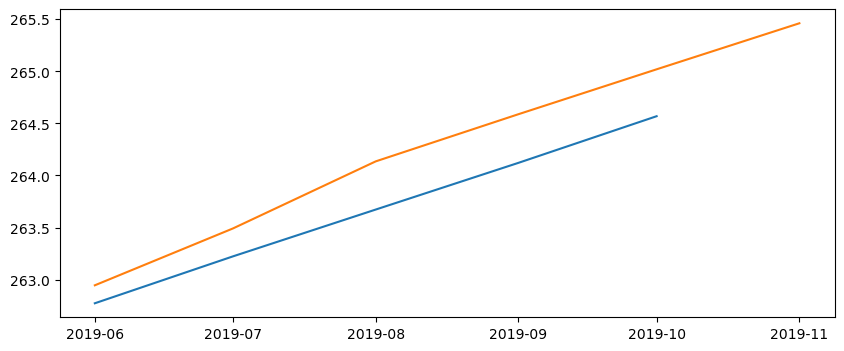

In [231]:
forecastValue = model_fit.forecast(steps=5)

plt.plot(forecastValue, )
plt.plot(df_com)
df_com

In [2]:
arima211 = [262.7579, 263.2026, 263.6477, 264.0923, 264.5364]
arima111 = [262.7723, 263.2227, 263.6722, 264.1207, 264.5682]
arima218 = [262.7864, 263.1853, 263.5927, 264.0458, 264.4641]
arima823 = [293.9277, 295.5277, 297.0822, 298.7799, 300.4771]
arima318 = [262.8411, 263.2224, 263.6491, 264.1474, 264.5406]
arimagarch = [262.7900, 263.2386, 263.6730, 264.1528, 264.6095]
r = [262.945, 263.491, 264.135, 264.588, 265.019]
r2 = [294.354, 295.275, 296.950, 298.660, 299.471]
mean_squared_error(r,arimagarch)

0.13165280999999113